In [17]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import tensorflow as tf
print(tf.test.gpu_device_name())
# See https://www.tensorflow.org/tutorials/using_gpu#allowing_gpu_memory_growth
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [18]:
import os
import pandas as pd

import numpy as np
from glob import glob
import cv2
import skimage
from skimage.transform import resize

from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
import keras.callbacks as kcall
from keras.optimizers import Adam
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

%matplotlib inline

In [19]:
train_dir = 'data/train'
validation_dir = 'data/validation'

In [4]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

data/train 0
data/train/MEL 3308
data/train/DF 4152
data/train/BKL 3275
data/train/BCC 4773
data/train/VASC 3488
data/train/AKIEC 3856
data/train/NV 4975


In [5]:
for root,dirs,files in os.walk(validation_dir):
    print (root, len(files))

data/validation 0
data/validation/MEL 1664
data/validation/DF 1632
data/validation/BKL 1479
data/validation/BCC 1692
data/validation/VASC 1484
data/validation/AKIEC 1552
data/validation/NV 1730


In [6]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32 

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True)


# target_size = (height, width)
target_size = (225, 300)


train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = target_size,       
        class_mode = 'categorical',
        shuffle = False)

validation_generator = train_datagen.flow_from_directory(
        validation_dir,
        target_size = target_size,        
        class_mode = 'categorical',
        shuffle = False)

Found 27827 images belonging to 7 classes.
Found 11233 images belonging to 7 classes.


In [7]:
## Intilizing variables
output_classes = 7

epochs = 50
droput_rate= 0.5
adam_opt = Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=1e-5)

xception_weights = 'pretrained-models/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [8]:
model = Sequential()

model.add(Xception(weights = xception_weights , include_top=False,pooling = 'avg'))
model.add(Dropout(rate=droput_rate))
model.add(Dense(units=output_classes, activation='softmax'))

model.layers[0].trainable = True

model.compile(loss='categorical_crossentropy',
              optimizer=adam_opt,
              metrics=['accuracy'])

In [9]:
history = model.fit_generator(train_generator,
    steps_per_epoch=2048,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps=1024)

Epoch 1/50


c:\users\reza-lab\appdata\local\programs\python\python35\lib\site-packages\keras_preprocessing\image.py:1131: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
c:\users\reza-lab\appdata\local\programs\python\python35\lib\site-packages\keras_preprocessing\image.py:1139: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


2048/2048 [==============================] - 1247s 609ms/step - loss: 0.8035 - acc: 0.7252 - val_loss: 0.4866 - val_acc: 0.8336
Epoch 2/50
2048/2048 [==============================] - 1226s 599ms/step - loss: 0.1786 - acc: 0.9446 - val_loss: 0.3417 - val_acc: 0.8766
Epoch 3/50
2048/2048 [==============================] - 1228s 599ms/step - loss: 0.0551 - acc: 0.9854 - val_loss: 0.3219 - val_acc: 0.8852
Epoch 4/50
2048/2048 [==============================] - 1228s 599ms/step - loss: 0.0193 - acc: 0.9959 - val_loss: 0.3270 - val_acc: 0.8854
Epoch 5/50
2048/2048 [==============================] - 1226s 598ms/step - loss: 0.0095 - acc: 0.9982 - val_loss: 0.3290 - val_acc: 0.8895
Epoch 6/50
2048/2048 [==============================] - 1225s 598ms/step - loss: 0.0062 - acc: 0.9987 - val_loss: 0.3657 - val_acc: 0.8895
Epoch 7/50
2048/2048 [==============================] - 1228s 600ms/step - loss: 0.0041 - acc: 0.9992 - val_loss: 0.3651 - val_acc: 0.8914
Epoch 8/50
2048/2048 [================

In [10]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])

Test Score:  0.4533282817527652
Test Accuracy:  0.9025


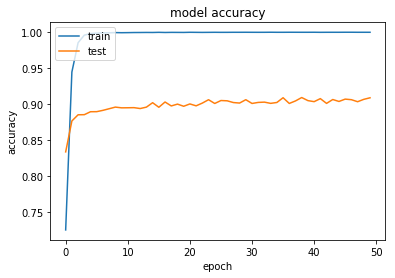

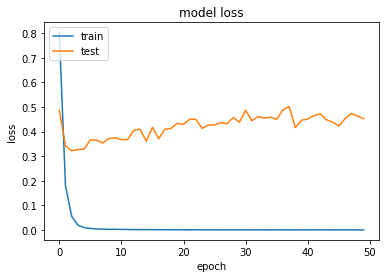

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

In [14]:
filename = validation_generator.filenames
truth = validation_generator.classes
label = validation_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

In [9]:
import keras.backend as K

def precision(y_true, y_pred):
    # Calculates the precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    # Calculates the recall
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fbeta_score(y_true, y_pred, beta=1):
    # Calculates the F score, the weighted harmonic mean of precision and recall.

    if beta < 0:
        raise ValueError('The lowest choosable beta is zero (only precision).')
        
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    bb = beta ** 2
    fbeta_score = (1 + bb) * (p * r) / (bb * p + r + K.epsilon())
    return fbeta_score

def fmeasure(y_true, y_pred):
    # Calculates the f-measure, the harmonic mean of precision and recall.
    return fbeta_score(y_true, y_pred, beta=1)

In [10]:
from keras.models import load_model
model = load_model("models/2.Xception2-Adam-without-Dropout-Model.h5", custom_objects={'fmeasure': fmeasure,  'recall': recall, 'precision': precision })
model.load_weights("models/2.Xception2-Adam-without-Dropout-Weights.h5")


In [11]:
filename = validation_generator.filenames
truth = validation_generator.classes
label = validation_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

predicts = model.predict_generator(validation_generator, steps=validation_generator.samples/validation_generator.batch_size, verbose=1)
predict_class = np.argmax(predicts, axis=1)
errors = np.where(predict_class != truth)[0]
print("No of errors = {}/{}".format(len(errors),validation_generator.samples))

352/351 [==============================] - 3702s 11s/step
No of errors = 1139/11233


In [18]:
model.save('models/2.Xception-Adam-without-Dropout-Model.h5')
model.save_weights('models/2.Xception-Adam-without-Dropout-Weights.h5')

In [19]:
##########################################################################################################

# Misclassified Images

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, load_img
# Show the errors
for i in range(len(errors)):
    pred_class = np.argmax(predictions[errors[i]])
    pred_label = idx2label[pred_class]
    
    title = 'Original label:{}, Prediction :{}, confidence : {:.3f}, class ID : {}'.format(
        fnames[errors[i]].split('/')[0],
        pred_label,
        predictions[errors[i]][pred_class], pred_class)
    
    original = load_img('{}/{}'.format(validation_dir,fnames[errors[i]]))
    plt.figure(figsize=[7,7])
    plt.axis('off')
    plt.title(title)
    plt.imshow(original)
plt.show()

___

In [10]:
from keras.applications import DenseNet201
model = Xception(weights = xception_weights, include_top=False, pooling = 'avg', input_shape = (225, 300, 3))

from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2
#Adding custom Layers 
x = model.output
# x = Flatten()(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation="softmax", kernel_regularizer=l2(0.0001), bias_regularizer=l2(0.0001))(x)

from keras.models import Model
# creating the final model 
model = Model(input = model.input, output = predictions)

model.compile(loss='categorical_crossentropy',
              optimizer= adam_opt,
              metrics = ["categorical_accuracy", fmeasure, recall, precision])

In [11]:
history = model.fit_generator(train_generator,
    steps_per_epoch=2048,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps=1024)

Epoch 1/50
2048/2048 [==============================] - 1279s 625ms/step - loss: 1.7460 - categorical_accuracy: 0.5352 - fmeasure: 0.5237 - recall: 0.4758 - precision: 0.5877 - val_loss: 1.0665 - val_categorical_accuracy: 0.7224 - val_fmeasure: 0.7221 - val_recall: 0.6707 - val_precision: 0.7840
Epoch 2/50
2048/2048 [==============================] - 1309s 639ms/step - loss: 0.8476 - categorical_accuracy: 0.8002 - fmeasure: 0.8013 - recall: 0.7741 - precision: 0.8316 - val_loss: 0.8152 - val_categorical_accuracy: 0.8099 - val_fmeasure: 0.8131 - val_recall: 0.7852 - val_precision: 0.8442
Epoch 3/50
2048/2048 [==============================] - 1312s 641ms/step - loss: 0.5418 - categorical_accuracy: 0.8953 - fmeasure: 0.8960 - recall: 0.8834 - precision: 0.9094 - val_loss: 0.7169 - val_categorical_accuracy: 0.8475 - val_fmeasure: 0.8547 - val_recall: 0.8370 - val_precision: 0.8739
Epoch 4/50
2048/2048 [==============================] - 1312s 641ms/step - loss: 0.3932 - categorical_accurac

In [12]:
score = model.evaluate_generator(validation_generator, steps=50)

print ('Test Score: ', score[0])
print ('Test Accuracy: ',score[1])
print ('fmeasure: ', score[2])
print ('Recall: ', score[3])
print ('Precision: ', score[4])

Test Score:  0.6869810661673545
Test Accuracy:  0.90125
fmeasure:  0.9017162108421326
Recall:  0.900625
Precision:  0.9028427410125732


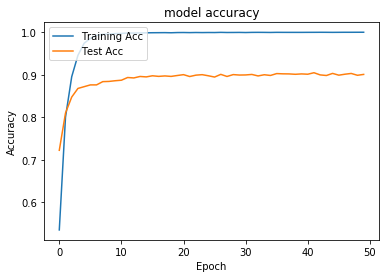

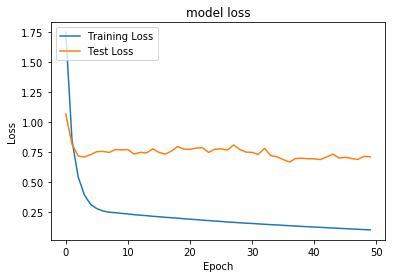

In [16]:
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

In [32]:
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["categorical_accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_categorical_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

NameError: name 'history' is not defined

<Figure size 432x288 with 0 Axes>

In [20]:
model.save('models/2.Xception2-Adam-without-Dropout-Model.h5')
model.save_weights('models/2.Xception2-Adam-without-Dropout-Weights.h5')

Confusion Matrix
[[1413   41   43    0   36   19    0]
 [  16 1624   18    0   14   20    0]
 [   5    4 1377    0   46   47    0]
 [  21   90   56 1444    0   20    1]
 [   6   14   29    1 1448  166    0]
 [   3   14   29    1   35 1647    1]
 [   2    2  263    4   41   31 1141]]


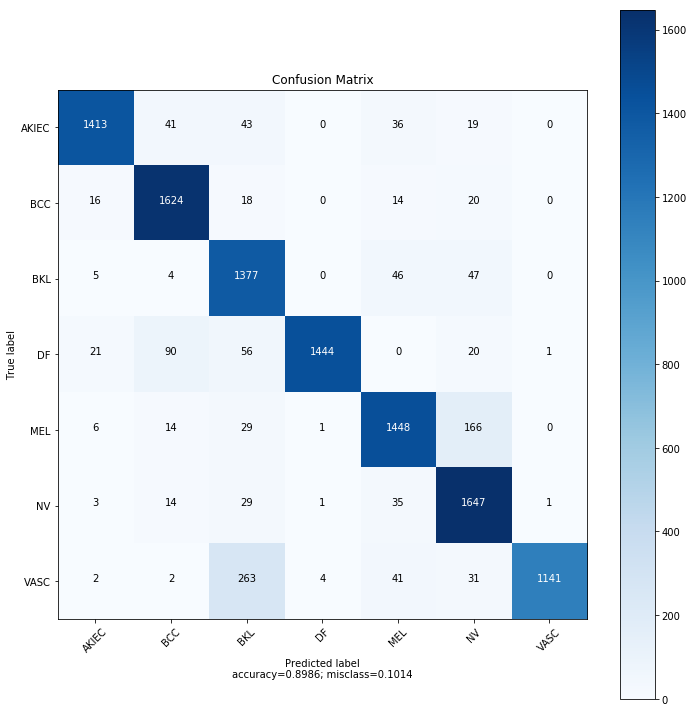

In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(truth,predict_class)

labels = []
for k,v in indexlabel.items():
    labels.append(v)
    
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig('plots/1.Xception-CM.png', bbox_inches='tight', dpi = 100) 
# fig.savefig('plots/1.Xception-CM.png') 
plt.figure(figsize=(10,10))


plot_confusion_matrix(cm, classes=labels,
                      title='Confusion Matrix')

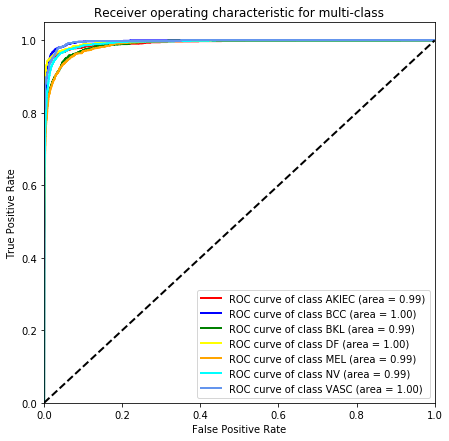

In [15]:
#ROC Curve for each class
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline  
from scipy import interp
from itertools import cycle




y_pred = predicts
y_pred_probabilities=y_pred

y_pred = np.argmax(y_pred,axis = 1) 
y_actual = validation_generator.classes

classnames=[]
for classname in validation_generator.class_indices:
    classnames.append(classname)

y_actual_binary = label_binarize(y_actual, classes=[0, 1, 2, 3, 4,5,6])
y_pred_binary = y_pred_probabilities#label_binarize(y_pred_probabilities, classes=[0, 1, 2, 3, 4])
n_classes=7
lw=2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_actual_binary[:, i], y_pred_binary[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_actual_binary.ravel(), y_pred_binary.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(7, 7))


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class')
plt.legend(loc="best")
plt.show()

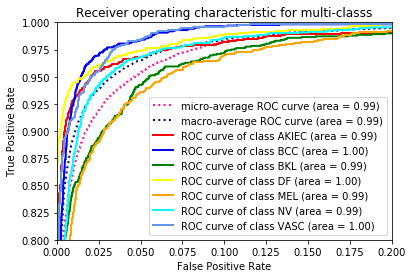

In [16]:
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)

plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)


colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

    
    
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-classs')
plt.legend(loc="lower right")
plt.savefig('plots/1.Xception-ROC.png') 
plt.show()

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report



confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[1413   41   43    0   36   19    0]
 [  16 1624   18    0   14   20    0]
 [   5    4 1377    0   46   47    0]
 [  21   90   56 1444    0   20    1]
 [   6   14   29    1 1448  166    0]
 [   3   14   29    1   35 1647    1]
 [   2    2  263    4   41   31 1141]]
             precision    recall  f1-score   support

      AKIEC       0.96      0.91      0.94      1552
        BCC       0.91      0.96      0.93      1692
        BKL       0.76      0.93      0.84      1479
         DF       1.00      0.88      0.94      1632
        MEL       0.89      0.87      0.88      1664
         NV       0.84      0.95      0.90      1730
       VASC       1.00      0.77      0.87      1484

avg / total       0.91      0.90      0.90     11233



In [27]:
print(model.summary())


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 225, 300, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 112, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 112, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 112, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [65]:
img_path = 'data/validation/BCC/hf_ISIC_0026321.jpg'

In [66]:
layer_name = 'block14_sepconv2_act'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [67]:
grads = K.gradients(loss, model.input)[0]

In [68]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [69]:


iterate = K.function([model.input], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])



In [70]:


# We start from a gray image with some noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step



In [71]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

In [72]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x


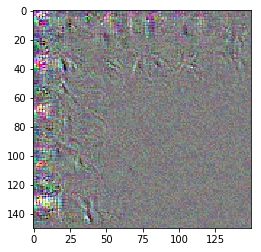

In [73]:
plt.imshow(generate_pattern('block6_sepconv1_act', 0))
plt.show()